In [0]:
from google.colab import drive
drive.mount('/content/drive')

import json
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import numpy as np

from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD
import keras.backend as K

import matplotlib.pyplot as plt
import os.path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd "/content/drive/My Drive/Vilnius University/Vilnius City Crime Prediction"

/content/drive/My Drive/Vilnius University/Vilnius City Crime Prediction


In [0]:
from importlib.machinery import SourceFileLoader
common = SourceFileLoader('common', "Modules/common.py").load_module()

In [0]:
!pip install gmplot

import gmplot

In [0]:
PARAMS = json.load(open('Params.json', 'r'))

#MODEL_PATH = "Data/Models/2kEpochsPlusData.h5"
MODEL_PATH = "Data/Models/evalFunk22.h5"

In [0]:
def FormatDataForLlstm(data, windowSize):
  data_in = []
  data_out = []
  for i in range(len(data) - windowSize):
      window = data[i:i+windowSize]
      x = window[:-1]
      y = window[-1, :]
      #y = y[0::8]
      data_in.append(x)
      data_out.append(y)
  return np.array(data_in), np.array(data_out)

def DataLoader(filePath, windowSize, split):
  data = pd.read_csv(filePath, delimiter="\t", index_col=0)
  #data = pd.read_csv(filePath)
  print(data.tail())
  trainingSize = int(len(data.index) * split)
  trainData = data.values[:trainingSize]
  testData = data.values[trainingSize:]
  print("Train len: {} Test len: {}".format(len(trainData), len(testData)))
  train_in, train_out = FormatDataForLlstm(trainData, windowSize)
  test_in, test_out = FormatDataForLlstm(testData, windowSize)
  return train_in, train_out, test_in, test_out

#train_x, train_y, test_x, test_y = DataLoader("Data/dataForModel+.csv", PARAMS["WindowSize"], PARAMS["DataSplit"])
train_x, train_y, test_x, test_y = DataLoader("Data/dataForModel.csv", PARAMS["WindowSize"], PARAMS["DataSplit"])

print(PARAMS["OverrideModel"])

      0  1  2  3  4  5  6  7  8  9  ...  26  27  28  29  30  31  32  33  34  \
1456  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
1457  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
1458  0  0  0  0  0  0  0  1  0  1  ...   0   0   0   0   0   0   0   1   0   
1459  0  0  0  0  0  0  0  0  0  0  ...   0   1   0   0   1   0   0   0   0   
1460  0  0  0  0  0  0  0  0  0  1  ...   0   0   0   0   0   0   0   0   0   

      35  
1456   0  
1457   0  
1458   0  
1459   0  
1460   0  

[5 rows x 36 columns]
Train len: 1314 Test len: 147
False


In [0]:
FEATURES_COUNT = train_x.shape[2]
OUTPUT_DIM = train_y.shape[1]
print("Feature count: {}; Output dim: {}".format(FEATURES_COUNT, OUTPUT_DIM))

Feature count: 36; Output dim: 36


In [0]:
def Drop(threshold, array):
  return K.sign(K.clip(array - threshold, 0, 1))

def precision(y_true, y_pred):
    # Calculates the precision
    y_pred = Drop(0.2, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    y_pred = Drop(0.2, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=PARAMS["BetaF"])

Building and training the model!
Train on 1175 samples, validate on 131 samples
Epoch 1/100
1175/1175 [==============================] - 1s 628us/step - loss: 0.0311 - acc: 0.0247 - fmeasure: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0406 - val_acc: 0.0305 - val_fmeasure: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
1175/1175 [==============================] - 0s 40us/step - loss: 0.0310 - acc: 0.0264 - fmeasure: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0406 - val_acc: 0.0305 - val_fmeasure: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
1175/1175 [==============================] - 0s 39us/step - loss: 0.0310 - acc: 0.0477 - fmeasure: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0406 - val_acc: 0.0458 - val_fmeasure: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/100
1175/1175 [==============================] - 0s 40us/st

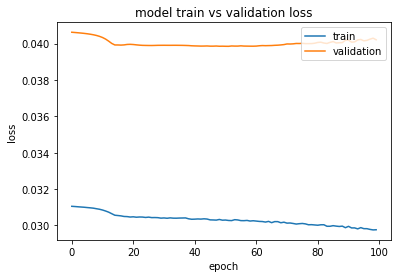

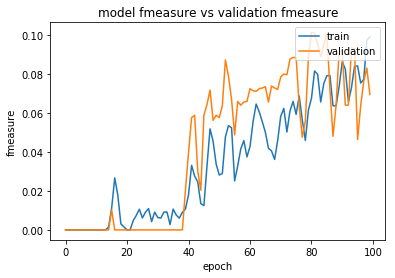

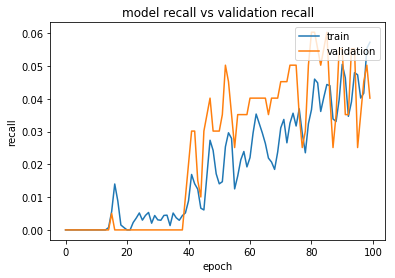

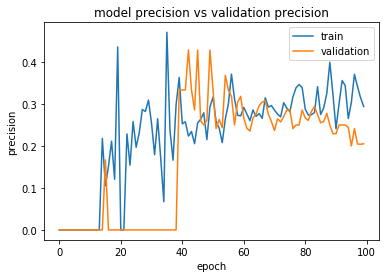

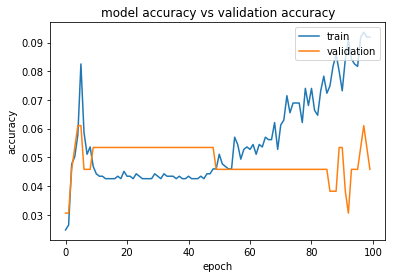

In [0]:
def PlotLossHistory(history): #TODO make into one function
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()
  
def PlotFmeasureHistory(history):
  plt.plot(history.history['fmeasure'])
  plt.plot(history.history['val_fmeasure'])
  plt.title('model fmeasure vs validation fmeasure')
  plt.ylabel('fmeasure')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()
  
def PlotAccHistory(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy vs validation accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()
  
def PlotRecallHistory(history):
  plt.plot(history.history['recall'])
  plt.plot(history.history['val_recall'])
  plt.title('model recall vs validation recall')
  plt.ylabel('recall')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()
  
def PlotPrecisionHistory(history):
  plt.plot(history.history['precision'])
  plt.plot(history.history['val_precision'])
  plt.title('model precision vs validation precision')
  plt.ylabel('precision')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

if os.path.isfile(MODEL_PATH) and not PARAMS["OverrideModel"]:
  print("Loading a pretrained model!")
  model = load_model(MODEL_PATH, custom_objects={'fmeasure': fmeasure, "recall": recall, "precision": precision})
else:
  print("Building and training the model!")
  model = Sequential()

  model.add(LSTM(100, input_shape=(None, FEATURES_COUNT), return_sequences=False))
  model.add(Dropout(0.4))

  #model.add(LSTM(100, return_sequences=True))

  #model.add(LSTM(100, return_sequences=False))
  #model.add(Dropout(0.4))

  #model.add(Flatten())
  model.add(Dense(OUTPUT_DIM, activation="softmax"))

  model.compile(loss="mse", optimizer=Adam(lr=PARAMS["LearningRate"]), metrics = ['accuracy', fmeasure, recall, precision])

  history = model.fit(
        train_x,
        train_y,
        epochs = PARAMS["EpochCount"],
        batch_size = PARAMS["BatchSize"],
        #validation_data = (test_x, test_y)
        validation_split = PARAMS["ValidationSplit"]
      )
  
  PlotLossHistory(history)
  PlotFmeasureHistory(history)
  PlotRecallHistory(history)
  PlotPrecisionHistory(history)
  PlotAccHistory(history)

  model.save(MODEL_PATH)

In [0]:
def VisualizeCrimeGrid(positionFrom, actual, expected, totalSize, gridSize, dropout,fileName):
  pos1 = tuple(common.OffsetCoordinate(positionFrom[0], positionFrom[1], totalSize[0], 0))
  posTo = tuple(common.OffsetCoordinate(positionFrom[0], positionFrom[1], totalSize[0], totalSize[1],))
  pos2 = tuple(common.OffsetCoordinate(positionFrom[0], positionFrom[1], 0, totalSize[1],))
  gmap = gmplot.GoogleMapPlotter((positionFrom[0] + posTo[0]) / 2.0, (positionFrom[1] + posTo[1]) / 2.0, 14)
  gmap.apikey = PARAMS["GoogleApiKey"]
  gmap.plot([positionFrom[0], pos1[0], posTo[0], pos2[0], positionFrom[0]], [positionFrom[1], pos1[1], posTo[1], pos2[1], positionFrom[1]],  'cornflowerblue', edge_width=2)
  
  for i in range(len(expected)):
    y, x = divmod(i, int(totalSize[0]/gridSize[0]))
    temp1 = tuple(common.OffsetCoordinate(positionFrom[0], positionFrom[1], x * gridSize[0], y * gridSize[1]))
    temp2 = tuple(common.OffsetCoordinate(temp1[0], temp1[1], gridSize[0], 0,))
    temp3 = tuple(common.OffsetCoordinate(temp1[0], temp1[1], gridSize[0], gridSize[1],))
    temp4 = tuple(common.OffsetCoordinate(temp1[0], temp1[1], 0, gridSize[1],))
    if expected[i] > 0:
      gmap.polygon([temp1[0], temp2[0], temp3[0], temp4[0], temp1[0]], [temp1[1], temp2[1], temp3[1], temp4[1], temp1[1]],  'cornflowerblue')
    else:  
      gmap.plot([temp1[0], temp2[0], temp3[0], temp4[0], temp1[0]], [temp1[1], temp2[1], temp3[1], temp4[1], temp1[1]],  'cornflowerblue', edge_width=2)
    if actual[i] > dropout:
      #gmap.plot([temp1[0], temp3[0]], [temp1[1], temp3[1]],  '#FF0000{}'.format(hex(255)), edge_width=15)
      gmap.plot([temp1[0], temp3[0]], [temp1[1], temp3[1]],  '#FF0000', edge_width=5, alpha=actual[i])
      gmap.plot([temp2[0], temp4[0]], [temp2[1], temp4[1]],  '#FF0000', edge_width=5, alpha=actual[i])
      gmap.marker((temp1[0] + temp3[0]) / 2.0, (temp1[1] + temp3[1]) / 2.0, color="red", title="{0:.2f}".format(actual[i]))
      
  gmap.draw("Data/ModelResults/" + fileName)
  
print(test_x.shape)
predicted = model.predict(test_x)
#predicted = np.reshape(predicted, (predicted.size,))
print(test_y.shape)
print(predicted.shape)

score = model.evaluate(test_x, test_y, verbose=0)
print('Test score/loss:', score[0])
print('Test accuracy:', score[1])
print('Test fmeasure:', score[2])
print('Test recall:', score[3])
print('Test precision:', score[4])

print(predicted[56])
print(test_y[56])
#VisualizeCrimeGrid(tuple(PARAMS["StartPosition"]), predicted[56], test_y[56], tuple(PARAMS["TotalSize"]), tuple(PARAMS["GridSize"]), -0.1, "AAA{}.html".format(56))
#for i in range(20):
#  VisualizeCrimeGrid(tuple(PARAMS["StartPosition"]), predicted[i], test_y[i], tuple(PARAMS["TotalSize"]), tuple(PARAMS["GridSize"]), -0.1, "{}.html".format(i))

(139, 7, 36)
(139, 36)
(139, 36)
Test score/loss: 0.04635180597253841
Test accuracy: 0.05755395704893757
Test fmeasure: 0.02513845463236459
Test recall: 0.014030232811145646
Test precision: 0.12338129565012541
[2.25903727e-02 1.99934542e-02 5.77351451e-03 4.26717475e-02
 1.65658735e-03 9.46963206e-03 3.19099203e-02 1.52599905e-02
 4.32390273e-02 1.40704289e-02 1.28815342e-02 5.14553115e-03
 1.31861202e-03 2.63876631e-03 2.20448691e-02 9.54613462e-03
 1.19755219e-03 3.88893252e-03 1.07566575e-02 7.08213029e-03
 2.10293140e-02 1.62704848e-03 1.11627649e-03 5.36219857e-04
 1.76703241e-02 1.01880892e-03 7.52694160e-03 4.51533161e-02
 1.06257992e-02 8.74182326e-04 5.32777631e-04 2.73338752e-04
 1.34761147e-02 4.49706763e-02 5.42701364e-01 7.73204817e-03]
[0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
